### Seleccioón de variables automática

###### En este notebook se aplicará la selección de variables secuencial (Sequential Feature Selection) para los modelos lineales, de modo que nos quedamos con las variables que más probabilidad tienen de estar en el modelo

#### Librerías y ajustes iniciales

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import *
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from modelos import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
pd.options.display.max_columns = 50 # para mostrar todas las columnas

In [6]:
X_train, X_test, y_train, y_test = sep_train_test()
# Eliminamos las columnas repetidas y las columnas temporales (visto en el notebook del analisis)
X_train = X_train.drop(columns=["Temperatura", 'wspd', 'anio', 'mes', 'dia', 'hora'])
X_test = X_test.drop(columns=["Temperatura", 'wspd', 'anio', 'mes', 'dia', 'hora'])

In [7]:
scaler = ColumnTransformer(
    transformers=[
        # no escalonamos las dummy de dirección de viento
        ("num", StandardScaler(), [c for c in X_train.columns if not c.startswith('wdir_')]),
    ],
    remainder='passthrough'
)
scaler.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['moonphase', 'temp', 'dewPt', 'heat_index',
                                  'rh', 'pressure', 'vis', 'wc', 'feels_like',
                                  'uv_index', 'Vviento', 'PeriodoOlas',
                                  'Lluvia', 'Nubosidad'])])

Vamos a evaluar los pesos sobre datos escalonados para evitar que las variables con mayor escala tomen mayor importancia en la regresión

Inicialmente tenemos 31 variable explicativa

In [51]:
X_train.shape

(4679, 31)

##### Definimos una funcion auxiliar

Se encarga de realizar seleccion de variables secuencial para el modelo pasado como parámetro. Devuelve la lista de las variables que se han escogido como "mejores".

Aparte de esto, muestra con dos gráficos (antes y después) los cambios de pesos de las variables.

In [39]:
def feature_selection_model(X_train, X_test, y_train, y_test, model, cols):
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    model.fit(X_train, y_train)
    importance = np.abs(model.coef_)
    feature_names = np.array(cols)
    ax[0].barh(width=importance, y=feature_names)
    ax[0].set_title('Todos los pesos')

    selc = SequentialFeatureSelector(
        estimator=model,
        cv=cv_folds(),
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
    )

    selc.fit(X_train, y_train)

    model.fit(X_train[:, selc.support_], y_train)
    importance = np.abs(model.coef_)
    feature_names = np.array(cols[selc.support_])
    ax[1].barh(width=importance, y=feature_names)
    ax[1].set_title('Pesos seleccionados')
    
    return feature_names


#### Modelo lineal sin regresión

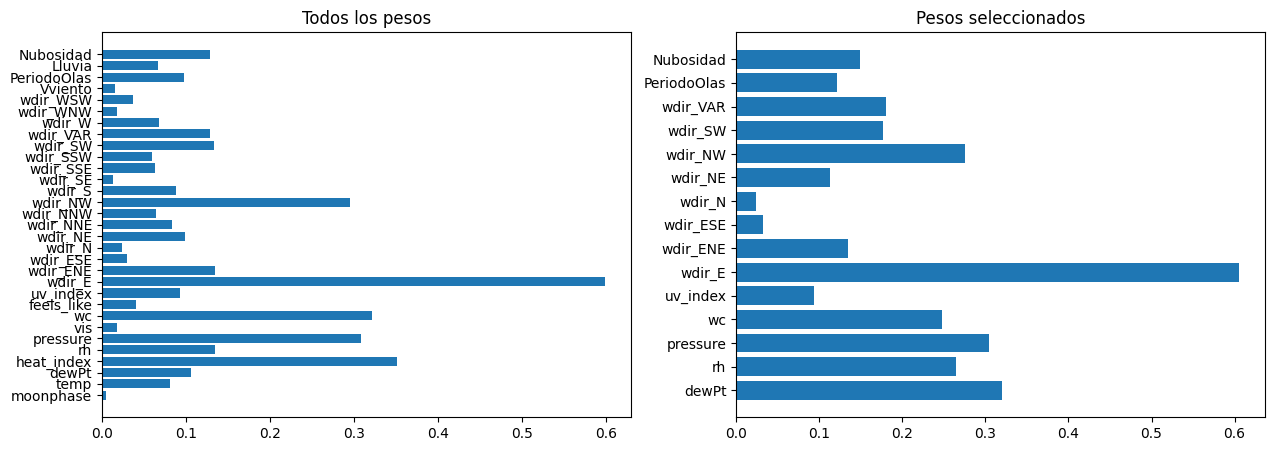

In [23]:
lin_no_reg_cols = feature_selection_model(scaler.transform(X_train), scaler.transform(X_test), y_train.to_numpy(), y_test.to_numpy(), LinearRegression(), X_train.columns)

#### Modelo RIDGE

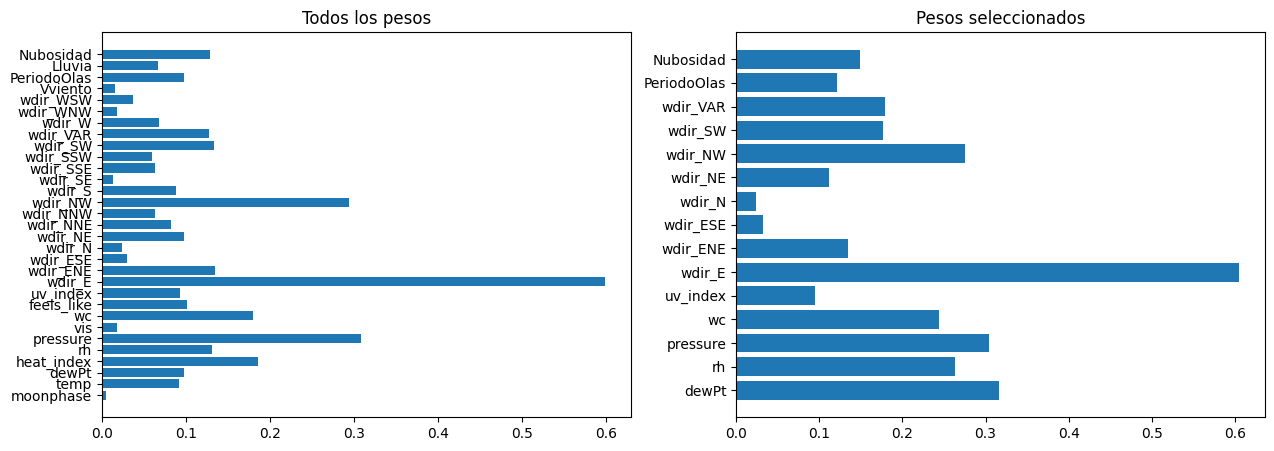

In [46]:
rid_cols = feature_selection_model(scaler.transform(X_train), scaler.transform(X_test), y_train.to_numpy(), y_test.to_numpy(), Ridge(random_state=RANDOM_SEED), X_train.columns)

Observamos que los modelos (sin hiperparámetros especificados) seleccionan las mismas columnas

In [47]:
(rid_cols != lin_no_reg_cols).sum()

0

Pasamos a tener 15 variables en vez de 31 iniciales

In [49]:
rid_cols, rid_cols.shape

(array(['dewPt', 'rh', 'pressure', 'wc', 'uv_index', 'wdir_E', 'wdir_ENE',
        'wdir_ESE', 'wdir_N', 'wdir_NE', 'wdir_NW', 'wdir_SW', 'wdir_VAR',
        'PeriodoOlas', 'Nubosidad'], dtype=object),
 (15,))

En el caso de Lasso y Elastic es difícil encontrar el mejor conjunto de columnas, pues habría que probar para muchos hiperparámetros y además realmente estos modelos por dentro ya se encargan de igualar los coeficientes a cero si ven que la variable no se usará

#### Modelo SVM

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UN

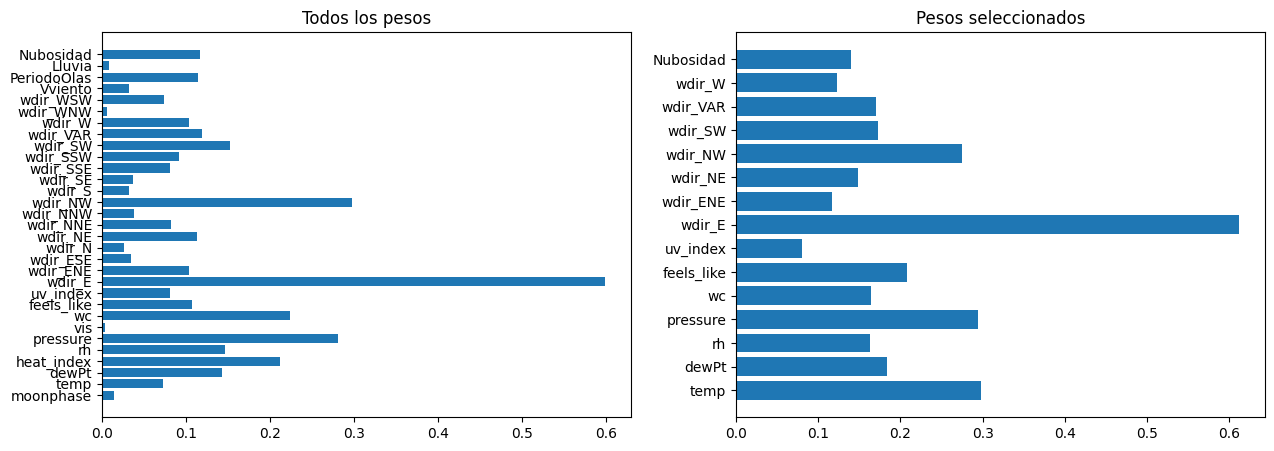

In [52]:
svm_cols = feature_selection_model(scaler.transform(X_train), scaler.transform(X_test), y_train.to_numpy(), y_test.to_numpy(), LinearSVR(random_state=RANDOM_SEED), X_train.columns)

In [54]:
svm_cols, svm_cols.shape

(array(['temp', 'dewPt', 'rh', 'pressure', 'wc', 'feels_like', 'uv_index',
        'wdir_E', 'wdir_ENE', 'wdir_NE', 'wdir_NW', 'wdir_SW', 'wdir_VAR',
        'wdir_W', 'Nubosidad'], dtype=object),
 (15,))